# Script IDF

## Librairies

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial

## Données et traitement: Extraction des Maximas par blocs: 

L'extraction des données est la même que pour les autres scripts, mais ici eviter d'utiliser temp=1 car la methode finale est basée sur l'idée d'un processus en minutes

In [27]:
Station = ['Aigle','Dole','Payerne','Bullet','Pully','Nyon']
num_sta = 4 # Choix de la station
Annees = [['8095','9524'],['8024']]
Temporalité = ['Minutes','Heures']
Temporalité2 = ['10 Minutes', 'Heures']
time_format = ['%M','']
temp = 0 # Choix du type de données (Horaire: 1 ou par 10 minutes: 0)
ratio = [6,1]

if temp == 1:
    raise PermissionError("Choisissez temp=0")

df=pd.read_csv("../Data/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][0]+".txt", sep=";", low_memory=False)

# Si on a les données minutes alors elles sont séparées en plusieurs fichier de 1980 à 2025 et il convient de les fusionner
if Temporalité[temp] == 'Minutes':
    df_temp=pd.read_csv("../Data/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][1]+".txt", sep=";", low_memory=False)

    last_time = df['time'].iloc[-1]
    df_temp_no_overlap= df_temp[df_temp['time'] > last_time]
    df = pd.concat([df, df_temp_no_overlap], ignore_index=True) # Ici on fusionne les données de 80 à 95 avec 95 à 25

del df['stn']
df = df.loc[df['time']>199491010000]
df.time = pd.to_datetime(df['time'], yearfirst=True, utc=False, format='%Y%m%d%H'+time_format[temp])
df.replace('-', 0, inplace=True)
df = df[~df.time.dt.year.isin([2025, 1980])] # J'enlève les années incomplètes manuellement
print(df)

                       time rre150z0
736279  1995-01-01 00:00:00      0.1
736280  1995-01-01 00:10:00      0.0
736281  1995-01-01 00:20:00      0.0
736282  1995-01-01 00:30:00      0.0
736283  1995-01-01 00:40:00      0.0
...                     ...      ...
2314226 2024-12-31 23:10:00      0.0
2314227 2024-12-31 23:20:00      0.0
2314228 2024-12-31 23:30:00      0.0
2314229 2024-12-31 23:40:00      0.0
2314230 2024-12-31 23:50:00      0.0

[1577952 rows x 2 columns]


In [28]:
N = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
num_years = df['time'].dt.year.nunique()
colonne_valeur = df.columns[1]

maximas = np.zeros(shape=[len(N),num_years])

for i, n in enumerate(N):
    print(f"Calcul des moyennes pour n={n} minutes")
    if n == 1:
        df[colonne_valeur] = pd.to_numeric(df[colonne_valeur], errors='coerce')
        df['year'] = df['time'].dt.year
        maximas[i] = np.array(df.groupby('year')[colonne_valeur].max())
    else:
        resultats = []
        groupes = [df.iloc[i:i+n] for i in range(0, len(df), n)]
        for groupe in groupes:
            if len(groupe) == n:  
                annee = groupe['time'].iloc[0].year
                moyenne = pd.to_numeric(groupe[colonne_valeur], errors='coerce').mean()
                resultats.append({'year': annee, f'{colonne_valeur}': moyenne})
        maximas[i] = np.array(pd.DataFrame(resultats).groupby('year')[colonne_valeur].max())

print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta]+'\n\tTemporalité: '+Temporalité2[temp]+f'\n\tAggregation: {n}')

Calcul des moyennes pour n=1 minutes
Calcul des moyennes pour n=2 minutes
Calcul des moyennes pour n=3 minutes
Calcul des moyennes pour n=4 minutes
Calcul des moyennes pour n=5 minutes
Calcul des moyennes pour n=6 minutes
Calcul des moyennes pour n=7 minutes
Calcul des moyennes pour n=8 minutes
Calcul des moyennes pour n=9 minutes
Calcul des moyennes pour n=10 minutes
Calcul des moyennes pour n=11 minutes
Calcul des moyennes pour n=12 minutes

Données sélectionnées: 

	Station: Pully
	Temporalité: 10 Minutes
	Aggregation: 12


# Ajustement des données à la loi de Gumbel:

### Par la méthode des moments

In [41]:
m1s = np.zeros(len(N))
m2s = np.zeros(len(N))

for i, n in enumerate(N):
    m1s[i] = maximas[i].mean()
    m2s[i] = maximas[i].std(ddof=1)**2  # J'utilise Bessel pour avoir une estimation non biaisée de la variance
    print(f"n={10*n} minutes: mean={m1s[i]}, std={m2s[i]}")


betas = np.sqrt(6*m2s)/np.pi # Il me semble qu'il y a une erreur dans le livre il faut prendre la racine carrée de la variance
alphas = m1s - betas * 0.5772 # 0.5772 est la constante d'Euler-Mascheroni, la formule vient du livre
print('alpha: ', alphas, '\t beta: ', betas) 

n=10 minutes: mean=11.053333333333333, std=9.32464367816092
n=20 minutes: mean=7.106666666666667, std=6.004954022988505
n=30 minutes: mean=5.513333333333334, std=4.035754789272031
n=40 minutes: mean=4.430833333333334, std=2.3803311781609198
n=50 minutes: mean=3.7013333333333334, std=1.8190326436781605
n=60 minutes: mean=3.17, std=1.2150268199233716
n=70 minutes: mean=2.953333333333333, std=1.0627717569786532
n=80 minutes: mean=2.6125000000000003, std=1.1208297413793102
n=90 minutes: mean=2.4244444444444446, std=1.0428216262239252
n=100 minutes: mean=2.129, std=0.47272655172413797
n=110 minutes: mean=2.1006060606060606, std=0.6567622304550204
n=120 minutes: mean=1.9263888888888887, std=0.5720981002554277
alpha:  [9.67907557 6.00384087 4.60923752 3.7364956  3.09435621 2.67392767
 2.48938237 2.13604499 1.96486871 1.81957381 1.73588893 1.58599063] 	 beta:  [2.38090395 1.91064761 1.56634757 1.20294133 1.05158891 0.85944618
 0.80379584 0.82545913 0.79621576 0.53608141 0.63187306 0.58974057]


### Par la méthode de la log-likelihood

In [42]:
parametres = np.zeros(shape=[len(N),2])
for i, n in enumerate(N):
    parametres[i] = stats.gumbel_r.fit(maximas[i])

alphas, betas = parametres[:,0], parametres[:,1]

print('alpha: ', alphas, '\t beta: ', betas) 

alpha:  [9.56122363 5.96502956 4.61991554 3.7555351  3.09080049 2.67217187
 2.50698123 2.19077206 2.02921103 1.81784609 1.78906169 1.6390427 ] 	 beta:  [2.91370831 2.05140221 1.64480624 1.24934891 1.09237614 0.88586934
 0.78306901 0.69085567 0.64724013 0.52187133 0.5036347  0.46364883]


# Verification graphique

/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_7314/1146672085.py:1: RuntimeWarning: divide by zero encountered in log
  gumbel_index_emp = -np.log(-np.log(np.arange(1, len(maximas[1])+1) / len(maximas[1])))


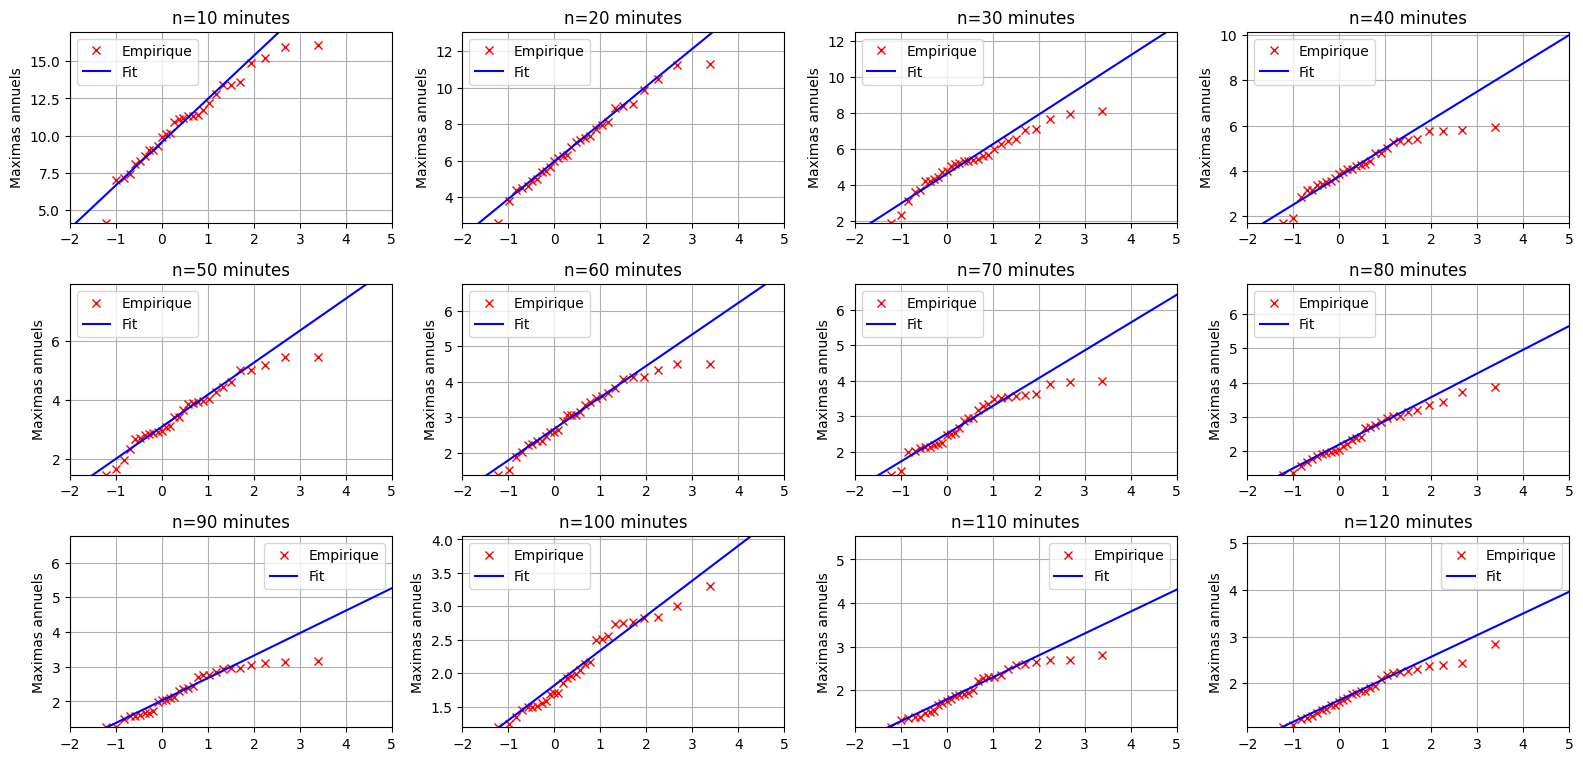

In [43]:
gumbel_index_emp = -np.log(-np.log(np.arange(1, len(maximas[1])+1) / len(maximas[1])))  
ligne = np.linspace(0,35,10)
gumbel_index_th = (np.tile(ligne, (len(N), 1)) - alphas[:, np.newaxis]) / betas[:, np.newaxis]

plt.figure(figsize=(16, 10))
for i, n in enumerate(N):
    plt.subplot(4, int(len(N)/3), i + 1)
    plt.tight_layout()
    plt.title(f"n={10*n} minutes")
    plt.plot(gumbel_index_emp, np.sort(maximas[i]), 'x', color='red', label='Empirique')
    plt.plot(gumbel_index_th[i], ligne, '-', color='blue', label='Fit')
    plt.legend()
    plt.ylim(np.min(maximas[i]),np.max(maximas[i]))
    plt.xlim(-2, 5)
    plt.ylabel('Maximas annuels')
    plt.grid('on')

# Verification par chi-carré
Avec $\alpha$ = 0.05, Remarque: Avec la méthode des moments pour déterminer $\alpha$ et $\beta$ le chi-carré échoue alors qu'il marche avec la méthode de la maximum likelihood (built-in dans la librairie scipy.stats)(le résultat en soit reste de 0.15 qui est quand-même relativement faible)

In [44]:
for i,n in enumerate(N):
    classes = np.linspace(np.min(maximas[i]), np.max(maximas[i]), len(maximas[i])//3)
    distribution_obs, _ = np.histogram(maximas[i], bins=classes)
    print('distribution_obs: ', distribution_obs)

    Gumbel_cumulative = np.exp(-np.exp(-(classes - alphas[i]) / betas[i]))
    distribution_th = np.diff(Gumbel_cumulative) * len(maximas[i])
    print('distribution_th: ', distribution_th)

    chi_carre = np.sum((distribution_obs - distribution_th)**2 / distribution_th)
    p_value = 1 - stats.chi2.cdf(chi_carre, len(classes) - 1 - 2) # On a 2 paramètres à estimer (alpha et beta)

    print('chi_carre: ', chi_carre, '\tdegré de liberté: ', len(classes) - 1 - 2, '\tp-value: ',p_value) 

    print('Le fit fonctionne \n' if p_value > 0.05 else 'Le fit ne fonctionne pas \n')

distribution_obs:  [1 0 5 4 6 5 4 2 3]
distribution_th:  [0.51372398 2.06651976 4.13896447 5.30202517 5.12337014 4.1527675
 3.01917108 2.05280564 1.33949825]
chi_carre:  5.726950534292348 	degré de liberté:  7 	p-value:  0.5719689098783952
Le fit fonctionne 

distribution_obs:  [1 5 5 6 5 3 2 2 1]
distribution_th:  [1.43222012 4.08478461 5.98272814 5.88055398 4.57576467 3.11068278
 1.95707404 1.17800972 0.69142979]
chi_carre:  1.254832954233303 	degré de liberté:  7 	p-value:  0.9896091010503051
Le fit fonctionne 

distribution_obs:  [ 2  5 10  7  3  2  0  0  1]
distribution_th:  [2.17232334 6.27899543 7.69034622 5.96568181 3.66560318 2.00495933
 1.03543079 0.5198595  0.25742446]
chi_carre:  4.9654064418739186 	degré de liberté:  7 	p-value:  0.6641849956600774
Le fit fonctionne 

distribution_obs:  [2 7 9 7 4 0 0 0 1]
distribution_th:  [2.43503411 6.86814656 7.94500133 5.79663354 3.36862803 1.75438406
 0.86719772 0.41818189 0.1993116 ]
chi_carre:  6.844840468009852 	degré de liberté: 

# Contrôle des incertitudes:
D'après la formule du livre

In [45]:
def std_quantile(gumbel_index,i):
    return betas[i]/np.sqrt(len(maximas[i]))*(np.sqrt(1.1086 + 0.514*gumbel_index + 0.697*gumbel_index**2))

# Plots

### Courbes à durées fixes

/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_7314/3380875252.py:6: RuntimeWarning: divide by zero encountered in divide
  Temps_retour = 1/(1 - np.exp(-np.exp(-(np.linspace(0,50,50) - alphas[i]) / betas[i])))


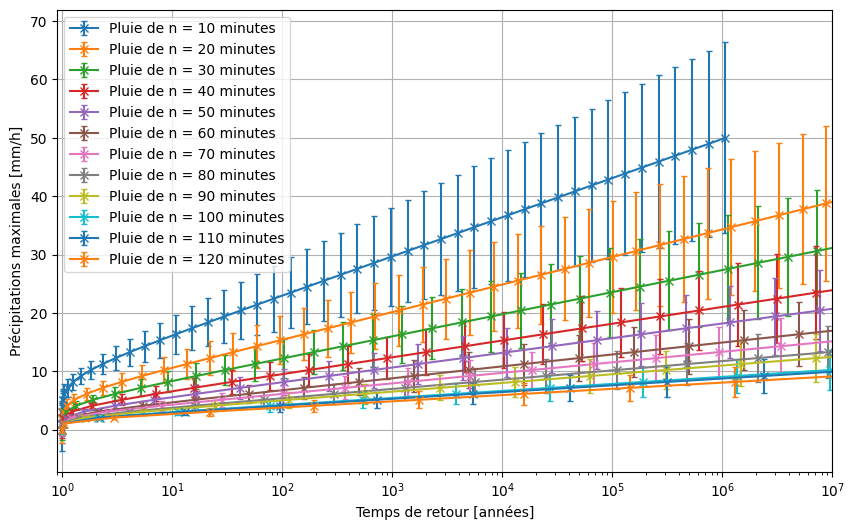

In [46]:
z = 1.29 # Pour un intervalle de confiance de 80%, z=1.29

plt.figure(figsize=(10, 6))
plt.subplot()
for i, n in enumerate(N):
    Temps_retour = 1/(1 - np.exp(-np.exp(-(np.linspace(0,50,50) - alphas[i]) / betas[i])))
    plt.errorbar(Temps_retour, np.linspace(0,50,50), yerr=2*z*std_quantile((np.linspace(0,50,50)-alphas[i])/betas[i],i), fmt='-x', label=f'Pluie de n = {10*n} minutes', capsize=2)
    plt.xlabel('Temps de retour [années]')
    plt.ylabel('Précipitations maximales [mm/h]')
    plt.xlim(0.9,10000000)
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

### Courbes IDF

#### Fit des paramètres Montana, c'est pour des pluies horaires. Si pluies 10 minutes, il faut faire Talbot et Montana

In [47]:
T = np.array([2,5,10,20,50,100])

montana_param = np.zeros(shape=[len(T),2])

gumbel_index_ = -np.log(-np.log((T-1)/T))
Frequencies = np.einsum('j,i->ij',gumbel_index_,betas) + alphas[:, np.newaxis]

lna = np.zeros(len(T))
b = np.zeros(len(T))
berr = np.zeros(len(T))
lnaerr = np.zeros(len(T))

for j, _ in enumerate(T):
    result = stats.linregress(np.log(N), np.log(Frequencies[:,j]))
    b[j] = result.slope
    lna[j] = result.intercept
    berr[j] = result.stderr
    lnaerr[j] = result.intercept_stderr

montana_param[:,0] = np.exp(lna)
montana_param[:,1] = -b

print('Montana parameters: ', montana_param)

Montana parameters:  [[11.07229092  0.72228036]
 [14.9341695   0.73397986]
 [17.49214892  0.73904388]
 [19.94631581  0.74274308]
 [23.12347076  0.74641759]
 [25.50455918  0.74859579]]


#### Montana curves

/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_7314/3879631019.py:6: RuntimeWarning: divide by zero encountered in power
  p1, = plt.plot(np.arange(0,200), montana_param[j,0]*(np.arange(0,200)**(-montana_param[j,1])), '-', label=f'Pluie de temps de retour = {t} années')


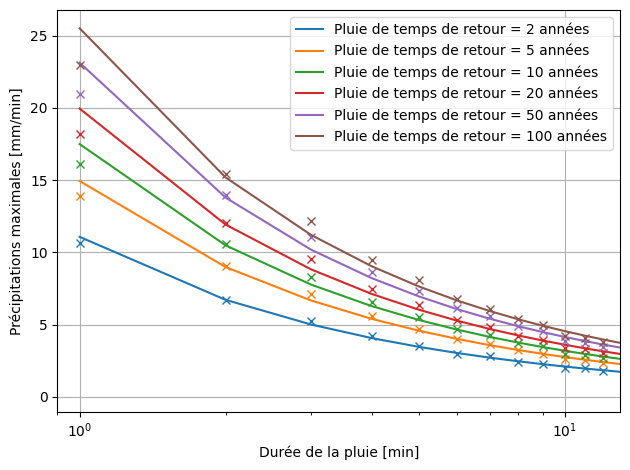

In [48]:
Frequencies_error = 2*z*std_quantile(gumbel_index_,np.arange(len(T)))

plt.figure()
plt.subplot()
for j, t in enumerate(T):
    p1, = plt.plot(np.arange(0,200), montana_param[j,0]*(np.arange(0,200)**(-montana_param[j,1])), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    plt.plot(N, Frequencies[:,j],'x', color=color)
plt.xlabel('Durée de la pluie [min]')
plt.ylabel('Précipitations maximales [mm/min]')
plt.xscale('log')
plt.xlim(0.9,13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Fit des courbes Talbot - Montana pour des pluies minutes: Spoiler le pivot ne converge pas

In [49]:
T = np.array([2,5,10,20,50,100])

montana_param = np.zeros(shape=[len(T),2])
talbot_param = np.zeros(shape=[len(T),2])

dpivot_ini = 1

a = montana_param[:,0]
b = montana_param[:,1]

gumbel_index_ = -np.log(-np.log((T-1)/T))
Frequencies = np.einsum('j,i->ij',gumbel_index_,betas) + alphas[:, np.newaxis]

def talbot_function(N, dpivot, a, b):
    return ((a/b)*dpivot**(1-b))/(dpivot/b-dpivot+N)

def montana_function(N, a, b):
    return a * N**(-b)

def residuals(dpivot, N, y, a, b, reg_lambda=0.1):
    model = talbot_function(N, dpivot, a, b)
    res = model - y
    reg = reg_lambda*dpivot
    return np.append(res, reg)

dpivots = dpivot_ini*np.ones(len(T))
lna = np.zeros(len(T))
bminus = np.zeros(len(T))
Nsup_final = np.zeros(shape=[len(T), len(N)])
Ninf_final = np.zeros(shape=[len(T), len(N)])

for j, t in enumerate(T):
    print(f'Temps de retour = {t} ans')
    while True:
        Nsup = N[N > dpivots[j]]
        Frequenciessup = Frequencies[N > dpivots[j], :]
        Ninf = N[N <= dpivots[j]]
        Frequenciesinf = Frequencies[N <= dpivots[j], :]

        result = stats.linregress(np.log(Nsup), np.log(Frequenciessup[:,j]))
        bminus[j] = result.slope
        lna[j] = result.intercept

        a[j] = np.exp(lna[j])
        b[j] = -bminus[j]

        fit_talbot = partial(talbot_function, a=a[j], b=b[j])
        result = scipy.optimize.least_squares(residuals, x0=[dpivots[j]], args=(Ninf, Frequenciesinf[:,j], a[j], b[j], 0))
        dpivots[j] = 3#result.x[0]
        print(dpivots[j])

        if len(N[N>dpivots[j]]) == len(Nsup):
            break

print('Pivot point: ', dpivots)

montana_param[:,0] = a
montana_param[:,1] = b


talbot_param[:,0] = (a/b)*dpivots**(1-b)
talbot_param[:,1] = dpivots*(1/b - 1)

print('Montana parameters: ', montana_param)
print('Talbot parameters: ', talbot_param)

Temps de retour = 2 ans
3.0
3.0
Temps de retour = 5 ans
3.0
3.0
Temps de retour = 10 ans
3.0
3.0
Temps de retour = 20 ans
3.0
3.0
Temps de retour = 50 ans
3.0
3.0
Temps de retour = 100 ans
3.0
3.0
Pivot point:  [3. 3. 3. 3. 3. 3.]
Montana parameters:  [[11.9707786   0.76098629]
 [17.13890282  0.80200559]
 [20.60094183  0.8197818 ]
 [23.94016895  0.83277455]
 [28.28068835  0.84568632]
 [31.5429522   0.85334287]]
Talbot parameters:  [[20.4542746   0.94225234]
 [26.56274583  0.74062233]
 [30.63195631  0.65951036]
 [34.54511045  0.60241557]
 [39.61931868  0.54741458]
 [43.42621819  0.51558572]]


### Choix arbitraire de dpivots en fct des resultas

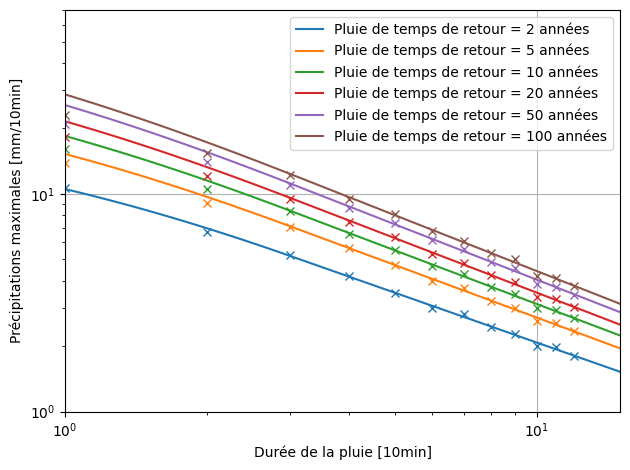

In [50]:
plt.figure()
plt.subplot()
for j, t in enumerate(T):
    p1, = plt.plot(np.linspace(dpivots[j],200), montana_param[j,0]*(np.linspace(dpivots[j],200)**(-montana_param[j,1])), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    p2, = plt.plot(np.linspace(1,dpivots[j],100), talbot_param[j,0]/(np.linspace(1,dpivots[j],100)+talbot_param[j,1]), '-', color=color)
    plt.plot(N, Frequencies[:,j],'x',color=color)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,15)
plt.ylim(1, 70)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()